# 1. Introdução

Esse trabalho tem como objetivo testar alguns modelos preditivos para criarmos uma série temporal de previsão dos valores futuros de fechamento do índice IBOVESPA.

# 2. Objetivo

# 3. Premissas

Atingir uma acuracidade acima de 70%.

# 4. Desenvolvimento

### Imports realizados

In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf     
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA  
from math import sqrt
import plotly.graph_objects as go
import yfinance as yf

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Carregamento dos Dados

In [2]:
symbol= '^BVSP'
start_date = '2000-01-01'
end_date = '2024-01-20'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,17098.0,17408.0,16719.0,16930.0,16930.0,0
2000-01-04,16908.0,16908.0,15851.0,15851.0,15851.0,0
2000-01-05,15871.0,16302.0,15350.0,16245.0,16245.0,0
2000-01-06,16237.0,16499.0,15977.0,16107.0,16107.0,0
2000-01-07,16125.0,16449.0,16125.0,16309.0,16309.0,0


In [4]:
# Verificando a estrutura do dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5954 entries, 2000-01-03 to 2024-01-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5954 non-null   float64
 1   High       5954 non-null   float64
 2   Low        5954 non-null   float64
 3   Close      5954 non-null   float64
 4   Adj Close  5954 non-null   float64
 5   Volume     5954 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 325.6 KB


In [5]:
# Resetando o index e convertendo para datetime

df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) 


In [6]:
df_ibovespa = df.sort_values(by='Date', ascending=True)

### Visualizando a série do índice IBOVESPA

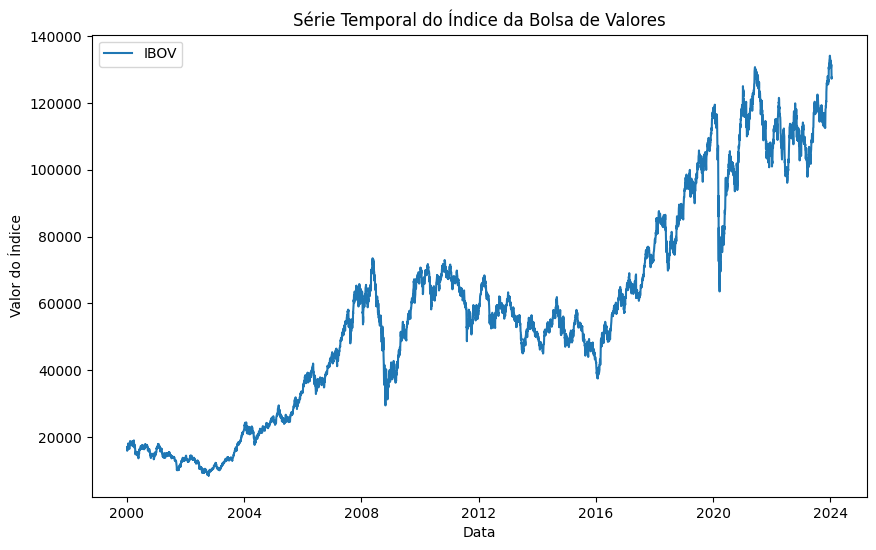

In [7]:
# Plotando a série temporal

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(df_ibovespa['Date'], df_ibovespa['Close'], label = 'IBOV')
plt.title('Série Temporal do Índice da Bolsa de Valores')
plt.xlabel('Data')
plt.ylabel('Valor do Índice')
plt.legend(loc='best')
plt.show()

Analisando rapidamente é possível vermos nos anos de 2009 e 2020 as duas principais quedas abruptas no indice, que representam, respectivamente, a **crise de 2009 e a pandemia global causada pela COVID-19**. Como pode ser visto destacado na imagem abaixo:

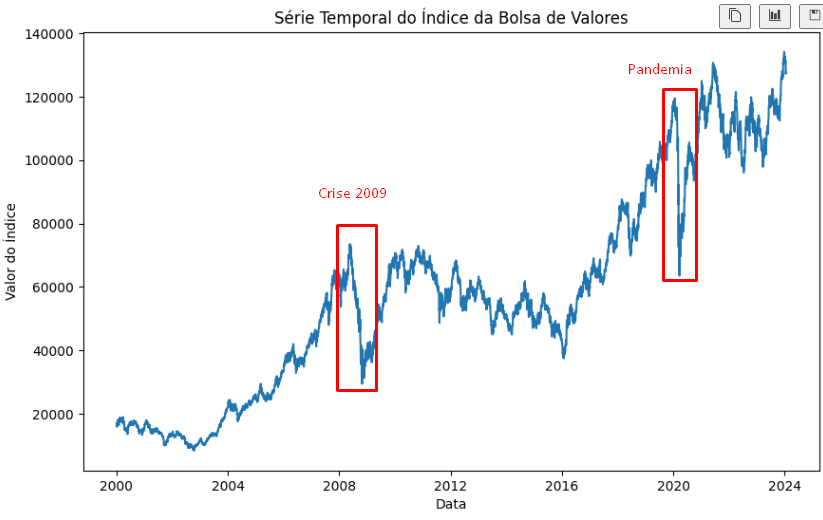

### Análise Exploratória dos dados

Iremos primeiramente decompor a série temporal para analisar a **Tendência, Sazonalidade e Ruído**. 

Para isso utilizaremos a biblioteca Statsmodel, e essa informação será crucial na escolha do modelo ideal para realizar a predição.

C:\Users\Sergio Velloso\AppData\Local\Temp\ipykernel_49344\2973951508.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eda = df_eda.asfreq('D').fillna(method='ffill')


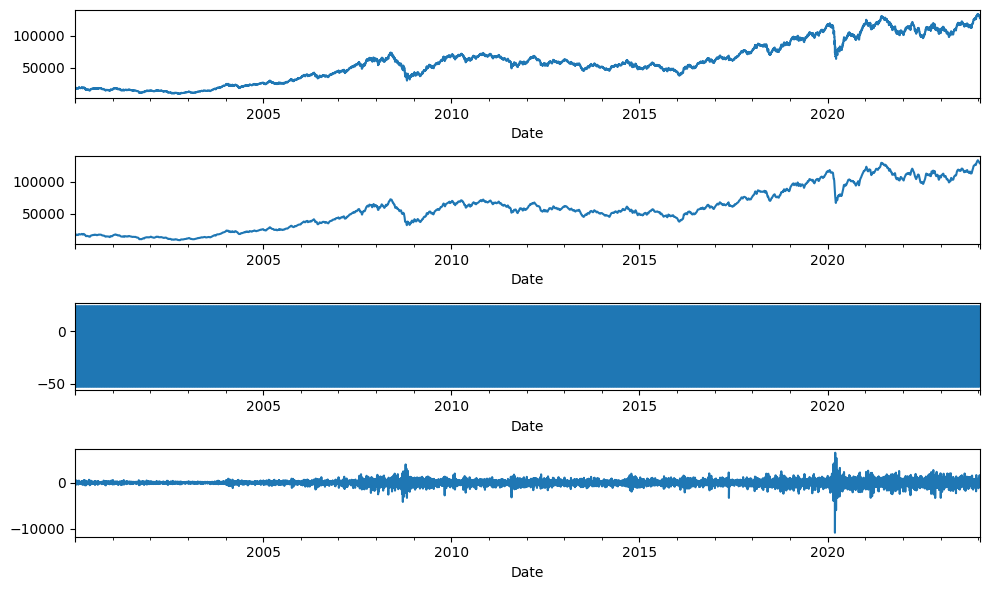

In [8]:
# Criando uma nova view para o dataframe original não ser comprometido com a análise
df_eda = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')

# Preenchendo os dias faltantes (FDS + Feriados)
df_eda = df_eda.asfreq('D').fillna(method='ffill')


# Decompondo a série temporal
resultados = seasonal_decompose(df_eda)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da série temporal, podemos observar que:

> **Tendência:** Embora haja bastante variabilidade, é possível observar que a tendência é de alta.

> **Sazonalidade:** O gráfico nos mostra que não existe uma sazonalidade clara no comportamento do índice.

> **Ruído:** Percebemos que os maiores ruídos foram causados nas duas quedas abruptas mencionadas anteriormente e que tirando isso, ele é totalmente aleatório.


Analisamos os últimos dois anos para entender melhor as variações no mercado e comparar com a análise dos especialistas do mercado.

In [9]:
df_atual = df_eda[-730:]
df_atual

,Close
Date,
2022-01-20,109102.0
2022-01-21,108942.0
2022-01-22,108942.0
2022-01-23,108942.0
2022-01-24,107752.0
...,...
2024-01-15,131521.0
2024-01-16,129294.0
2024-01-17,128524.0


In [10]:
data_min = df_atual.index.min()
data_max = df_atual.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min} e finaliza-se no dia {data_max}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2022-01-20 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


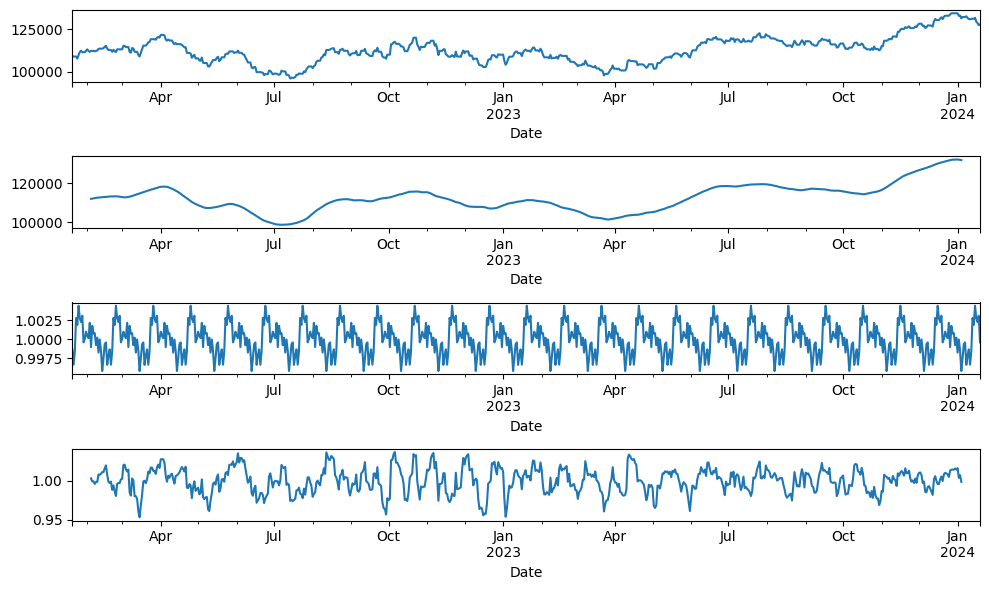

In [11]:
# Decompondo a série temporal
resultados = seasonal_decompose(df_atual, model='multiplicative', period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da nova série temporal, podemos observar que:

> **Tendência:**  Permance sendo de alta.

> **Sazonalidade:**  Aparentemente existe uma ciclicidade, mas acreditamos que possa ser causada pelo método *"asfreq('D').fillna(method='ffill')"* que utilizamos para fazer o preenchimento dos feriados e finais de semana

> **Ruído:** Percebemos que retirando o período das quedas abruptas, muda bastante.

Repetiremos o processo utilizando o método de interpolação para o preenchimento das datas

In [12]:
df_atual2 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date').asfreq('D').interpolate(method='linear')[-730:]

data_min2 = df_atual2.index.min()
data_max2 = df_atual2.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min2} e finaliza-se no dia {data_max2}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2022-01-20 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


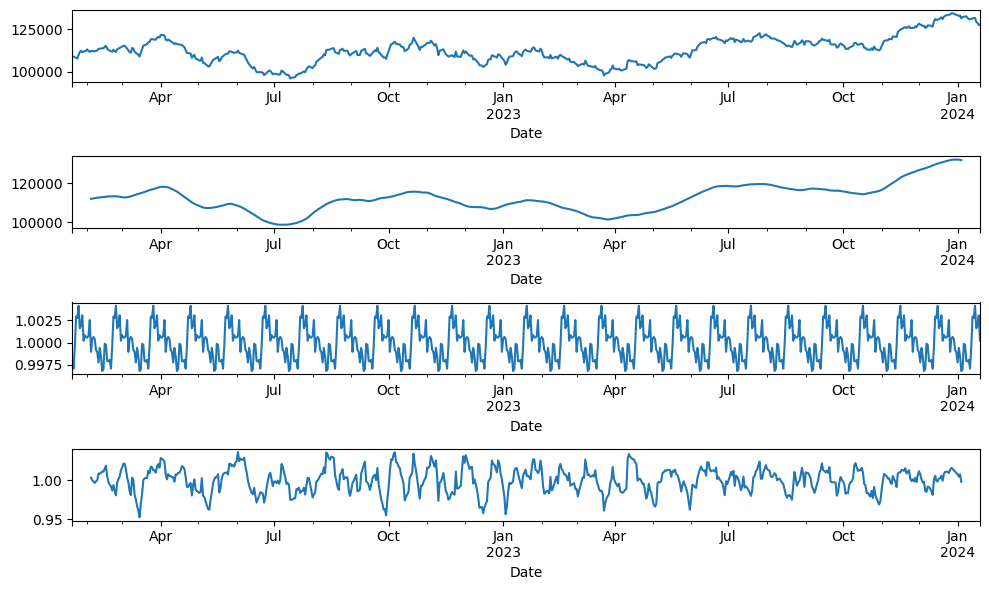

In [13]:
# Decompondo a série temporal
resultados = seasonal_decompose(df_atual2, model='multiplicative', period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Analisando a decomposição da série temporal utilizando o método de interpolação, podemos observar que:

Não houveram modificações tão significativas na decomposição.

Como último método, utilizaremos a decomposição sem inferir valores.

In [14]:
# Como último método, utilizaremos a decomposição sem inferir valores.

df_atual3 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')[-730:]

data_min3 = df_atual3.index.min()
data_max3 = df_atual3.index.max()

print(f'Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia {data_min3} e finaliza-se no dia {data_max3}')

Estaremos analisando os últimos 730 dias da nossa base, que inicia-se no dia 2021-02-17 00:00:00 e finaliza-se no dia 2024-01-19 00:00:00


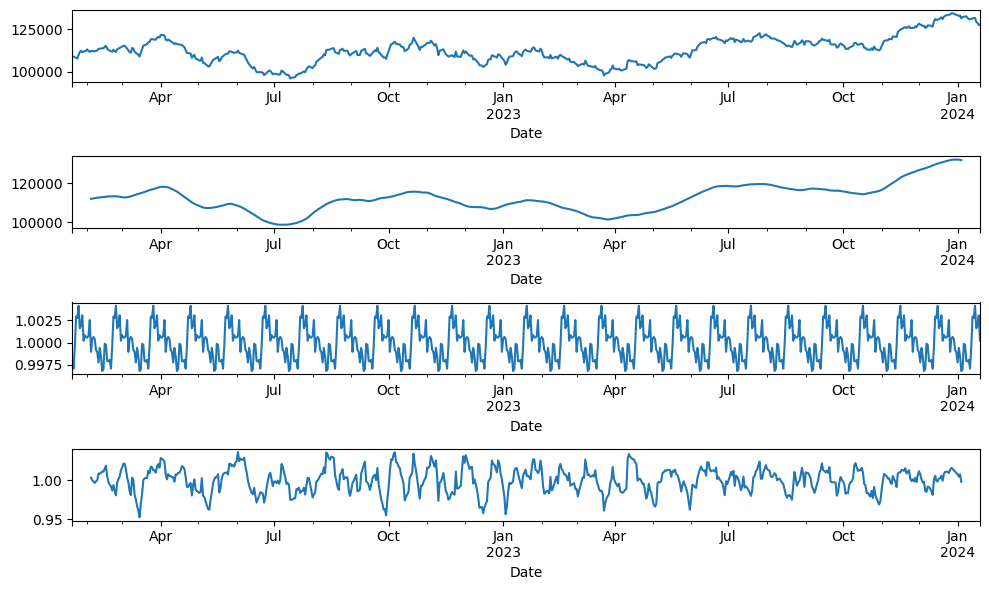

In [15]:
import statsmodels.api as sm

# Decompondo a série temporal com o tsa
resultados = sm.tsa.seasonal_decompose(df_atual2, model='multiplicative',  period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

Mesmo retirando os valores inputados "forçadamente" o comportamento permaneceu. Portanto assumiremos que existe sazonalidade, mas é muito impactada pelos ruídos, o que pro fechamento de um índice de bolsa de valores é complicado.

**Seguiremos com a análise exploratória sem inputar valores no entanto utilizando a base inteira para análise.** Para isso, resgataremos o nosso df_eda e não utilizaremos nenhum método de "fill" (preenchimento), usando também o statsmodels.tsa.seasonal.

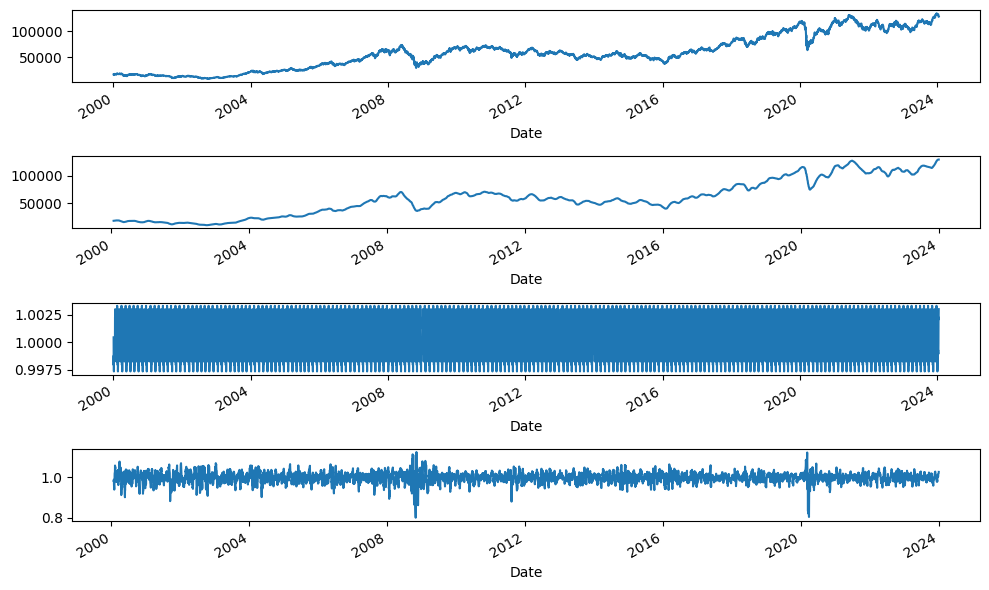

In [16]:
# Criando uma nova view para o dataframe original não ser comprometido com a análise
df_eda_2 = df_ibovespa.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']).set_index('Date')

# Decompondo a série temporal
resultados = sm.tsa.seasonal_decompose(df_eda_2, model='multiplicative',  period=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,6))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

# COLOCAR ANÁLISES SOBRE O INDICE 

### Desenvolvendo o Modelo de Predição

Começaremos pelo modelo clássico de **Média Móvel.** Vamos utilizar esta técnica para um N de 5 dias, que seria o período de 1 semana da bolsa de valores.

In [17]:
df = pd.DataFrame(df[['Close','Date']])
df.set_index('Date', inplace=True)


In [18]:
df['MA_window_5'] = df['Close'].rolling(5).mean().shift() 

In [19]:
df.head(10) # Os primeiros 5 valores ficarão nulos.

,Close,MA_window_5
Date,,
2000-01-03,16930.0,NaN
2000-01-04,15851.0,NaN
2000-01-05,16245.0,NaN
2000-01-06,16107.0,NaN
2000-01-07,16309.0,NaN
2000-01-10,17022.0,16288.4
2000-01-11,16573.0,16306.8
2000-01-12,16617.0,16451.2
2000-01-13,17298.0,16525.6


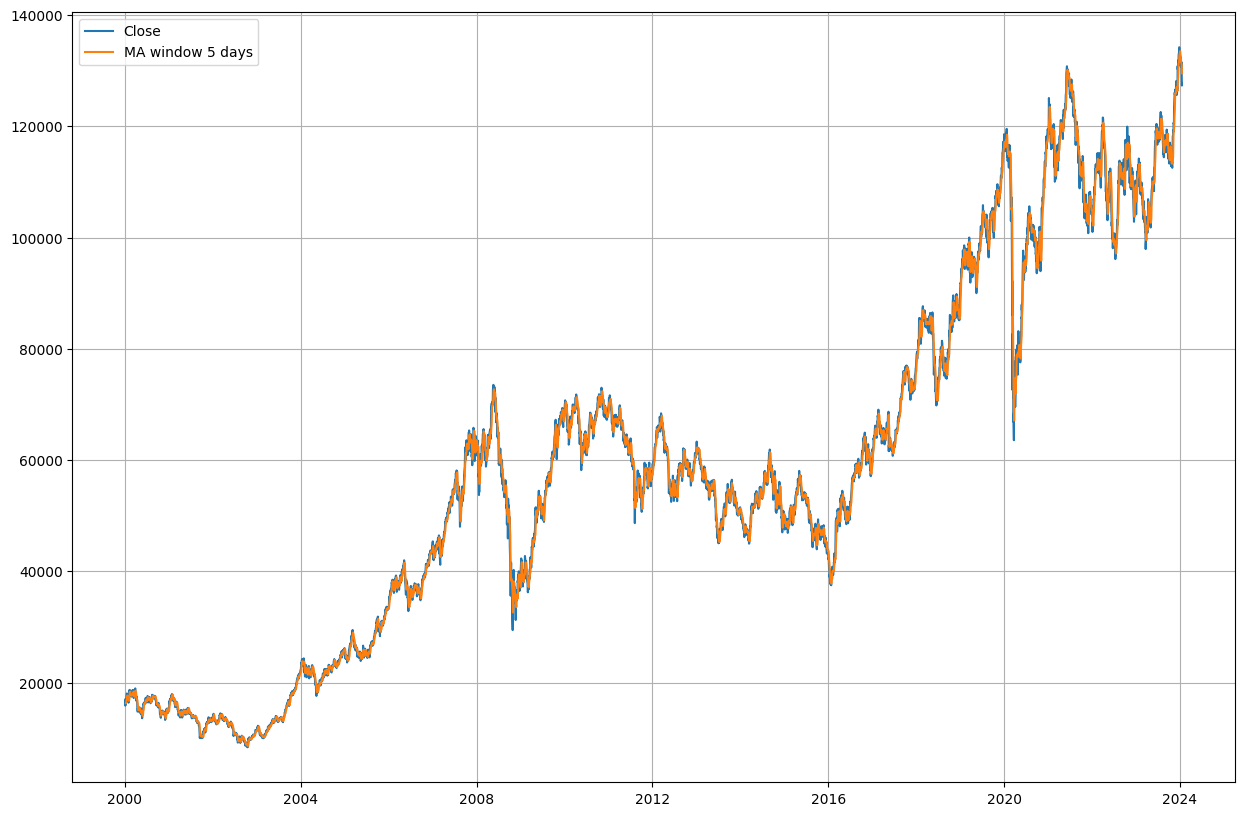

In [20]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_window_5'], label='MA window 5 days')
plt.legend(loc='best')
plt.show()

Reduzimos a base para verificar o mesmo modelo para apenas o último ano. 

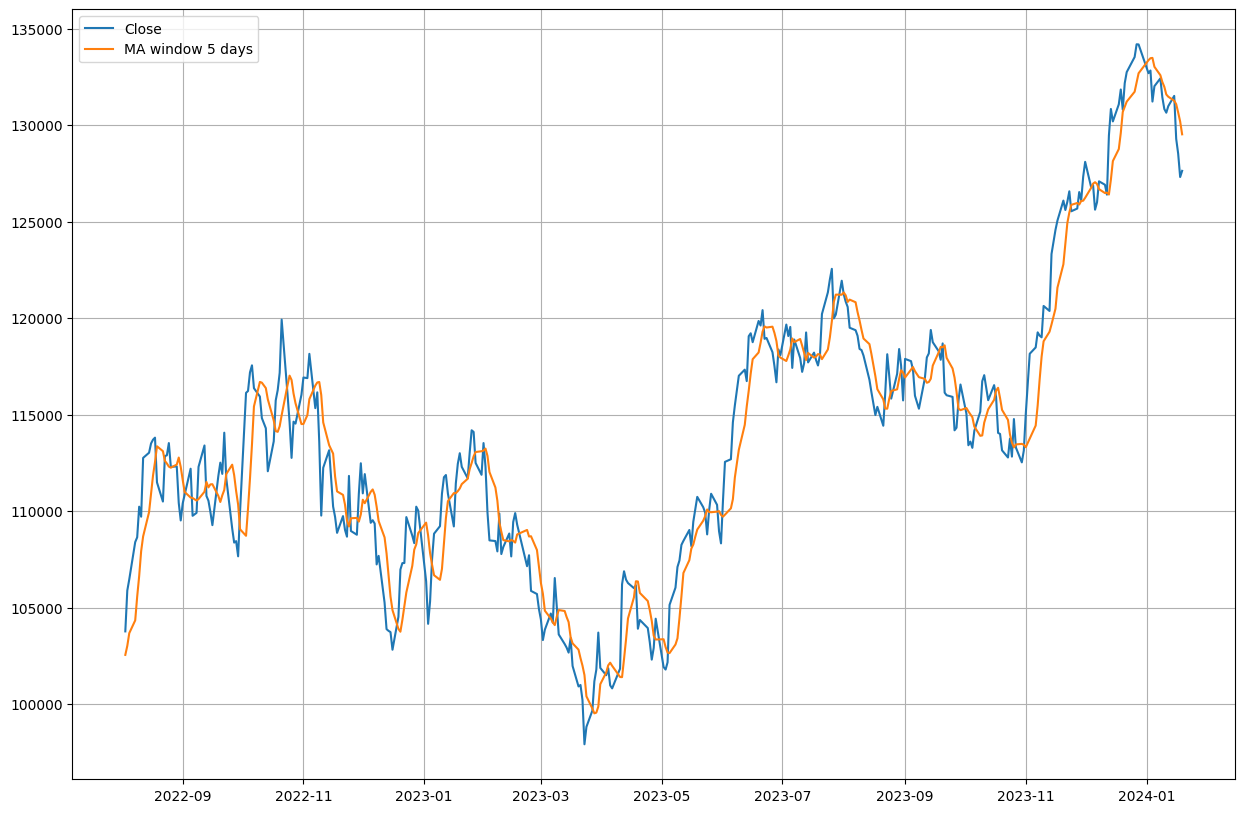

In [21]:
dias = 365

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-dias:], label='Close')
plt.plot(df['MA_window_5'][-dias:], label='MA window 5 days')
plt.legend(loc='best')
plt.show()

Construindo o modelo

In [22]:
# Preechendo com NaN os valores da coluna de MA_window_5_forward_5

df['MA_window_5_forward_5'] = np.NaN 

In [23]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)] 

In [24]:
window_size = 5
forward_days = 5

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_5_forward_5'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_5_forward_5')] = mean


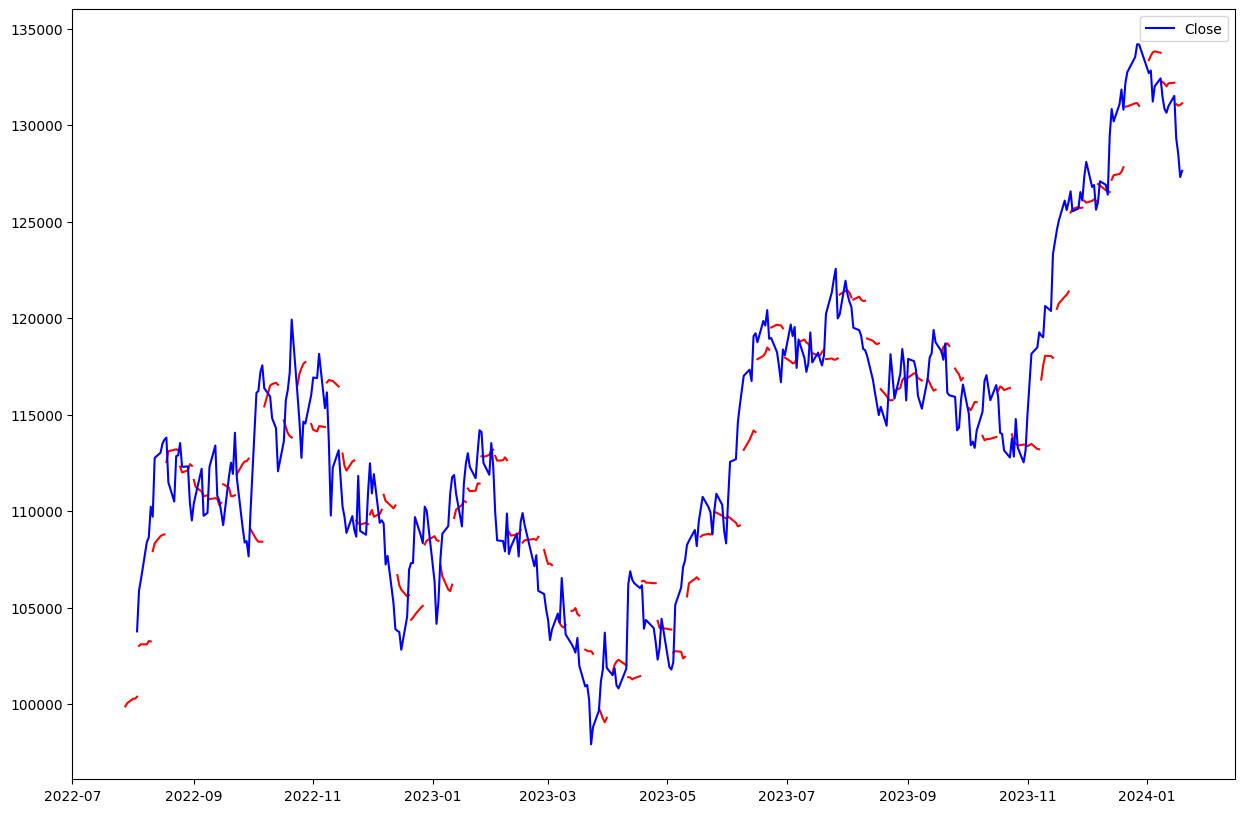

In [25]:
plt.figure(figsize = (15,10))

size = len(df)-dias - (len(df)-dias)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_5_forward_5'][index:index+forward_days], color='r')

plt.plot(df['Close'][-dias:], color='b', label='Close')
plt.legend(loc='best')
plt.show()

Com a análise das retas vermelhas, verificamos que o algoritmo não previu com margem de erro aceitável. 

Para escolher o modelo ideal, faremos o teste para verificar a estacionariedade através do Teste de Dickey-Fuller Aumentado (ADF).

In [26]:
adf_result = adfuller(df_eda_2['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.6860540960010798
p-value: 0.8503288474200337
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -0.6860540960010798
Valor-p: 0.8503288474200337
Valores Críticos:
   1%: -3.4314509975133816
   5%: -2.862026538823416
   10%: -2.5670289822848287


Verificamos que a nossa **Série Temporal no momentão não é estacionária** porque o valor do 'p' está muito altom e o valor do Teste Estatístico está muito maior do que os valores críticos.

Transformamos a série em estacionária para utilizarmos o modelo ARIMA.

Subtraindo a média móvel dos dados transformados pela transformação logarítmica.

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

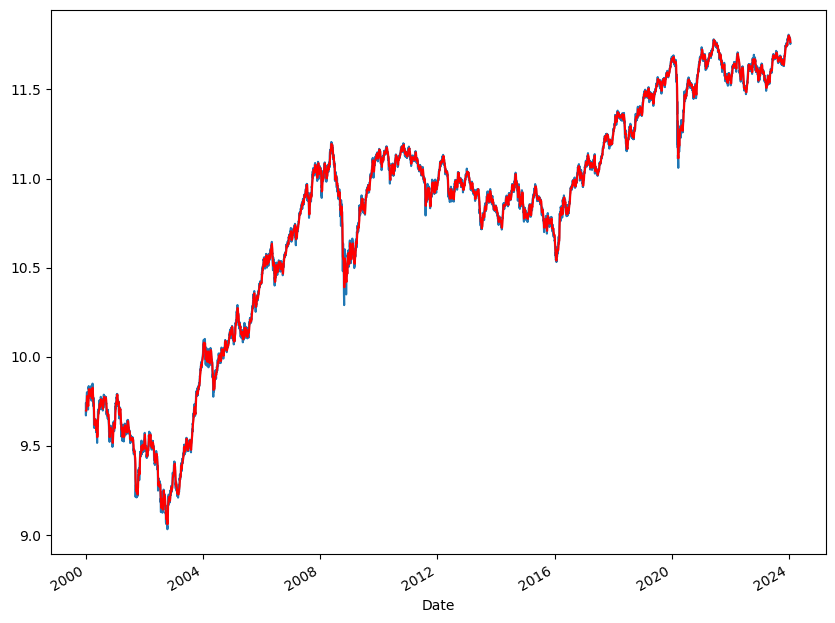

In [27]:
# Aplicando logaritimo

df_indice_log = np.log(df_eda_2)
ma_log = df_indice_log.rolling(5).mean()


f, ax = plt.subplots(figsize=(10,8))
df_indice_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r') 
plt.tight_layout

Nota-se que a escala diminui drásticamente, suavizando a série.

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

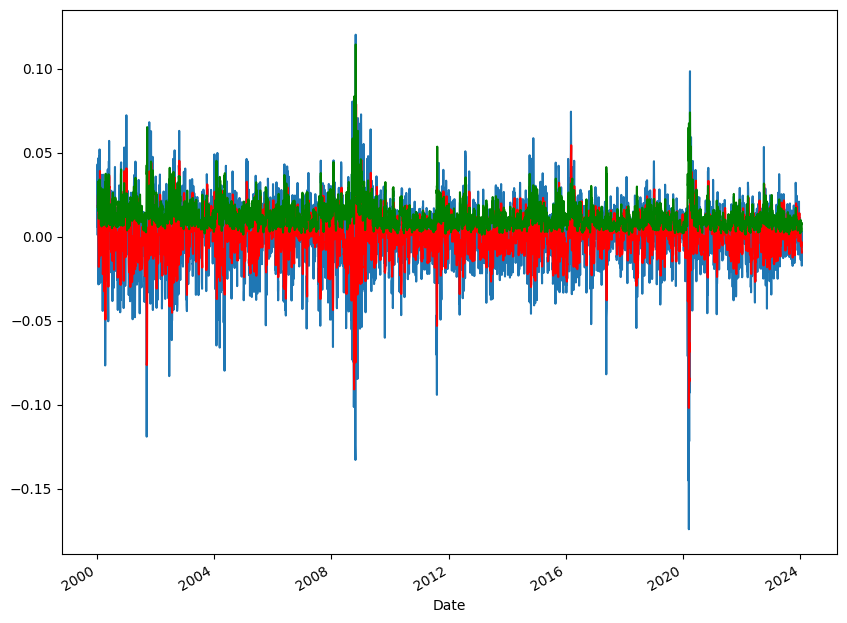

In [28]:
# Subtraindo a média móvel.

df_s = (df_indice_log - ma_log).dropna()

ma_s = df_s.rolling(5).mean()

std = df_s.rolling(5).std()

f, ax = plt.subplots(figsize=(10,8))
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r') 
std.plot(ax=ax, legend=False, color='g') 
plt.tight_layout

In [29]:
# Verificando novamente o teste de ADF

result_s = adfuller(df_s.Close.values)

print('Teste ADF')
print(f'Teste Estatístico: {result_s[0]}')
print(f'P-Value: {result_s[1]}')
print('Valores críticos:')

for key, value in result_s[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste Estatístico: -16.674227788720174
P-Value: 1.5356825758227012e-29
Valores críticos:
	1%: -3.4314526683830535
	5%: -2.8620272770559723
	10%: -2.567029375266065


Verificamos que agora o P-Value está muito próximo de 0 e que o Teste Estatístico está muito menor do que os valores críticos, o que sugere estacionariedade.

Com os dados estacionarios, verificamos agora as Autocorrelações.

In [30]:
lag_acf = acf(df_s, nlags=20)
lag_pacf = pacf(df_s, nlags=20, method='ols')

In [31]:
# Intervalo de confiança para o ACF/PACF
ci = 1.96/np.sqrt(len(df_s))

trace_acf = go.Scatter(x = np.arange(len(lag_acf)),y = lag_acf, mode='lines', name='ACF')
trace_pacf = go.Scatter(x = np.arange(len(lag_pacf)),y = lag_pacf, mode='lines', name='PACF')

# Linhas de intervalo de confiança superior e inferior
trace_ci_upper = go.Scatter(x = np.arange(len(lag_acf)),y = [ci]*len(lag_acf), mode='lines', name='Confidence Interval Upper Bound', line=dict(dash='dash', color='gray'))
trace_ci_lower = go.Scatter(x = np.arange(len(lag_acf)),y = [-ci]*len(lag_acf), mode='lines', name='Confidence Interval Lower Bound', line=dict(dash='dash', color='gray'))


fig_acf = go.Figure(data=[trace_acf, trace_ci_upper, trace_ci_lower])
fig_pacf = go.Figure(data=[trace_pacf, trace_ci_upper, trace_ci_lower])

fig_acf.show()
fig_pacf.show()


No gráfico ACF, percebemos que a curva toca a linha y=0,0 em x=7. Portanto Q =7

No gráfico de PACF, percebemos que a curva toca a linha y=0,0 em x=4. Portanto P =4

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'RSS: 1.1718')

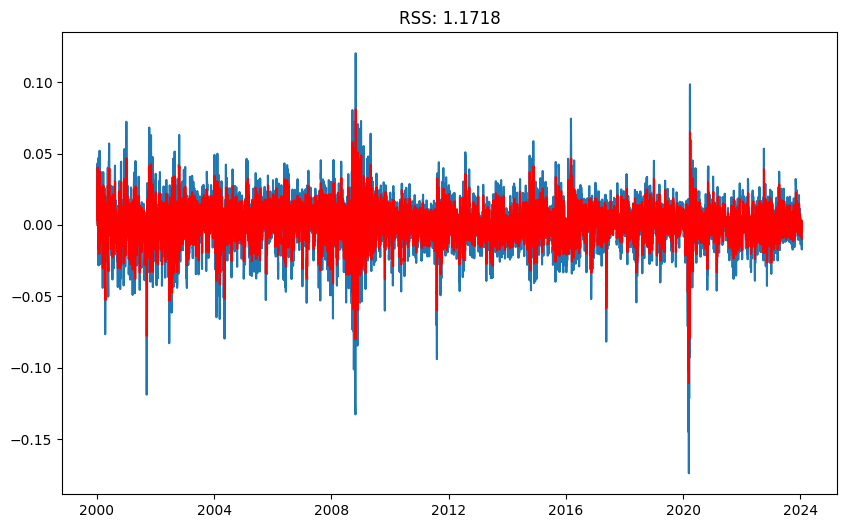

In [32]:
#AR Model
model = ARIMA(df_s, order=(4,1,7))#(p,d,q)
results_AR = model.fit()
plt.plot(df_s)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_s['Close'])**2))


Fazendo a validação do modelo com o MAPE.

In [33]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = df_s.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = df_indice_log['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(df_s['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 1198.71%


Com esse resultado de MAPE, aparentemente as previsões desse modelo estão muito distantes dos valores de fechamento da bolsa reais.

Utilizamos então outro modelo mais robusto chamado Prophet. Separaremos os dados em treino e teste.

In [34]:
df_prophet = df_eda_2.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
df_prophet.head()

,ds,y
0,2000-01-03,16930.0
1,2000-01-04,15851.0
2,2000-01-05,16245.0
3,2000-01-06,16107.0
4,2000-01-07,16309.0


In [35]:
treino = df_prophet.sample(frac=0.8, random_state=0)
valid = df_prophet.drop(treino.index)
print(f'training data size : {treino.shape}')
print(f'testing data size : {valid.shape}')

training data size : (4763, 2)
testing data size : (1191, 2)


In [36]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(treino)
dataFramefuture = modelo.make_future_dataframe(periods=12, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

16:37:27 - cmdstanpy - INFO - Chain [1] start processing
16:37:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-04,15770.747268,11613.765080,26186.857890,15770.747268,15770.747268,2874.751028,2874.751028,2874.751028,1042.644438,...,73.060016,73.060016,73.060016,1759.046574,1759.046574,1759.046574,0.0,0.0,0.0,18645.498296
1,2000-01-05,15765.663744,11575.163370,25552.993968,15765.663744,15765.663744,2771.428684,2771.428684,2771.428684,1042.644438,...,-75.136754,-75.136754,-75.136754,1803.921001,1803.921001,1803.921001,0.0,0.0,0.0,18537.092428
2,2000-01-06,15760.580220,11888.228547,26577.344494,15760.580220,15760.580220,3056.350616,3056.350616,3056.350616,1042.644438,...,172.071464,172.071464,172.071464,1841.634714,1841.634714,1841.634714,0.0,0.0,0.0,18816.930835
3,2000-01-07,15755.496695,11997.202727,26423.268684,15755.496695,15755.496695,2899.679811,2899.679811,2899.679811,1042.644438,...,-14.833658,-14.833658,-14.833658,1871.869030,1871.869030,1871.869030,0.0,0.0,0.0,18655.176506
4,2000-01-10,15740.246123,11507.633020,25695.567397,15740.246123,15740.246123,3064.309520,3064.309520,3064.309520,1042.644438,...,105.499849,105.499849,105.499849,1916.165233,1916.165233,1916.165233,0.0,0.0,0.0,18804.555643


c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



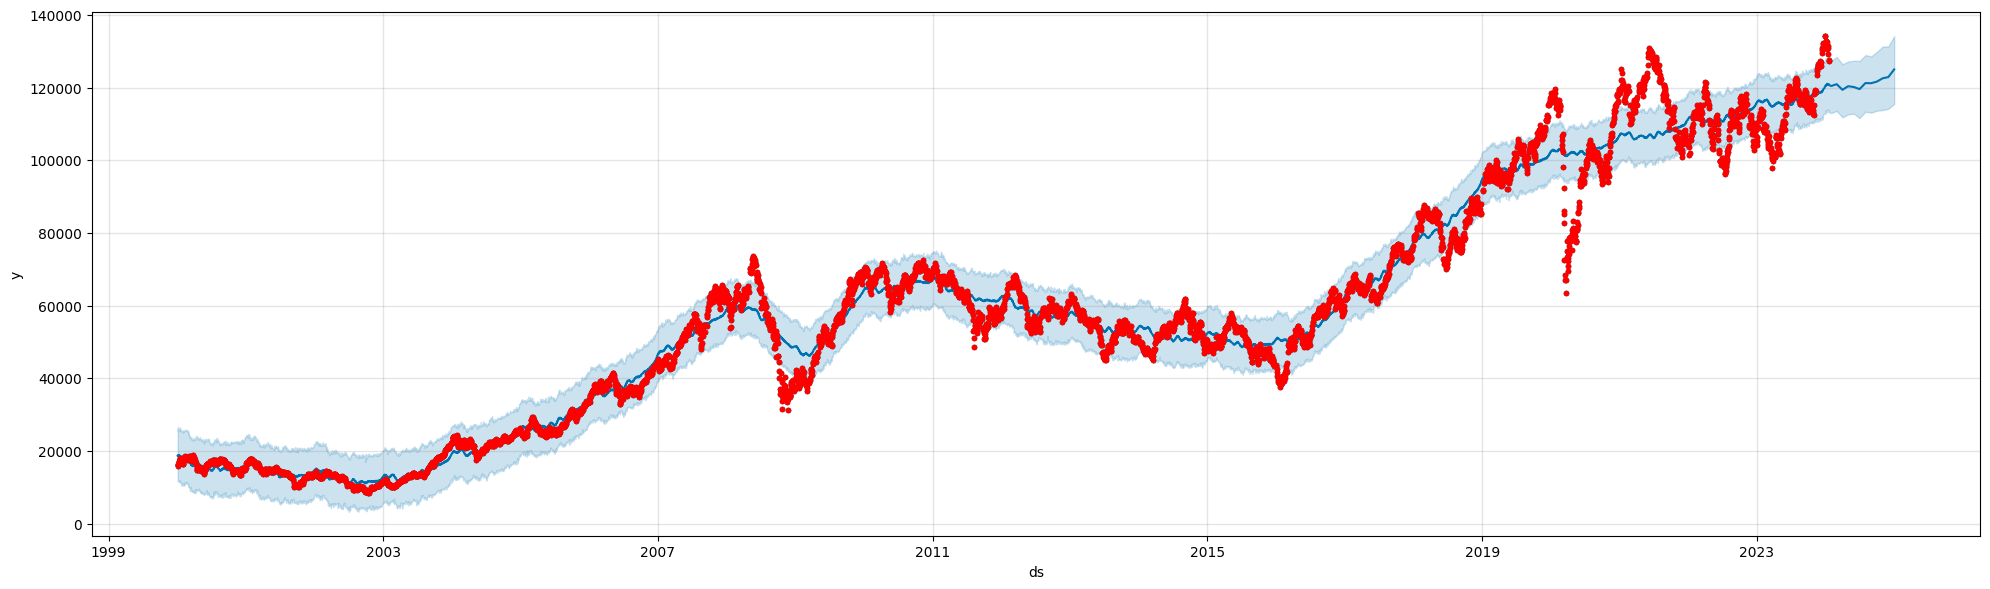

In [37]:
modelo.plot(previsao, figsize=(20,6))
plt.plot(treino['ds'], treino['y'], '.r')

Vericficando a qualidade do modelo

In [38]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = treino[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 7.13%


Refazendo esse mesmo modelo, porém com um dataset menor (últimos 2 anos)

In [39]:
df_prophet_2_anos = df_prophet[-730:]

In [40]:
#Separando em base de treino e teste
treino_dois_anos = df_prophet_2_anos.sample(frac=0.8, random_state=0)
valid_2_anos = df_prophet_2_anos.drop(treino_dois_anos.index)
print(f'training data size : {treino_dois_anos.shape}')
print(f'testing data size : {valid_2_anos.shape}')

training data size : (584, 2)
testing data size : (146, 2)


In [41]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(treino_dois_anos)
dataFramefuture = modelo.make_future_dataframe(periods=12, freq='M')
previsao_2_anos = modelo.predict(dataFramefuture)
previsao_2_anos.head()

16:37:29 - cmdstanpy - INFO - Chain [1] start processing


16:37:29 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-17,117823.942328,111034.900526,117698.261021,117823.942328,117823.942328,-3579.180130,-3579.180130,-3579.180130,-6093.266442,...,-186.580235,-186.580235,-186.580235,2700.666547,2700.666547,2700.666547,0.0,0.0,0.0,114244.762198
1,2021-02-18,117889.323004,110968.827992,117498.244419,117889.323004,117889.323004,-3721.893786,-3721.893786,-3721.893786,-6093.266442,...,-253.092165,-253.092165,-253.092165,2624.464821,2624.464821,2624.464821,0.0,0.0,0.0,114167.429218
2,2021-02-19,117954.703681,110745.675007,117690.701855,117954.703681,117954.703681,-3859.366554,-3859.366554,-3859.366554,-6093.266442,...,-311.058076,-311.058076,-311.058076,2544.957964,2544.957964,2544.957964,0.0,0.0,0.0,114095.337127
3,2021-02-22,118150.845710,110743.326833,117490.824996,118150.845710,118150.845710,-4140.490562,-4140.490562,-4140.490562,-6093.266442,...,-343.177622,-343.177622,-343.177622,2295.953502,2295.953502,2295.953502,0.0,0.0,0.0,114010.355148
4,2021-02-23,118216.226386,110284.501175,117577.242190,118216.226386,118216.226386,-4311.050080,-4311.050080,-4311.050080,-6093.266442,...,-429.401995,-429.401995,-429.401995,2211.618356,2211.618356,2211.618356,0.0,0.0,0.0,113905.176306


c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Sergio Velloso\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



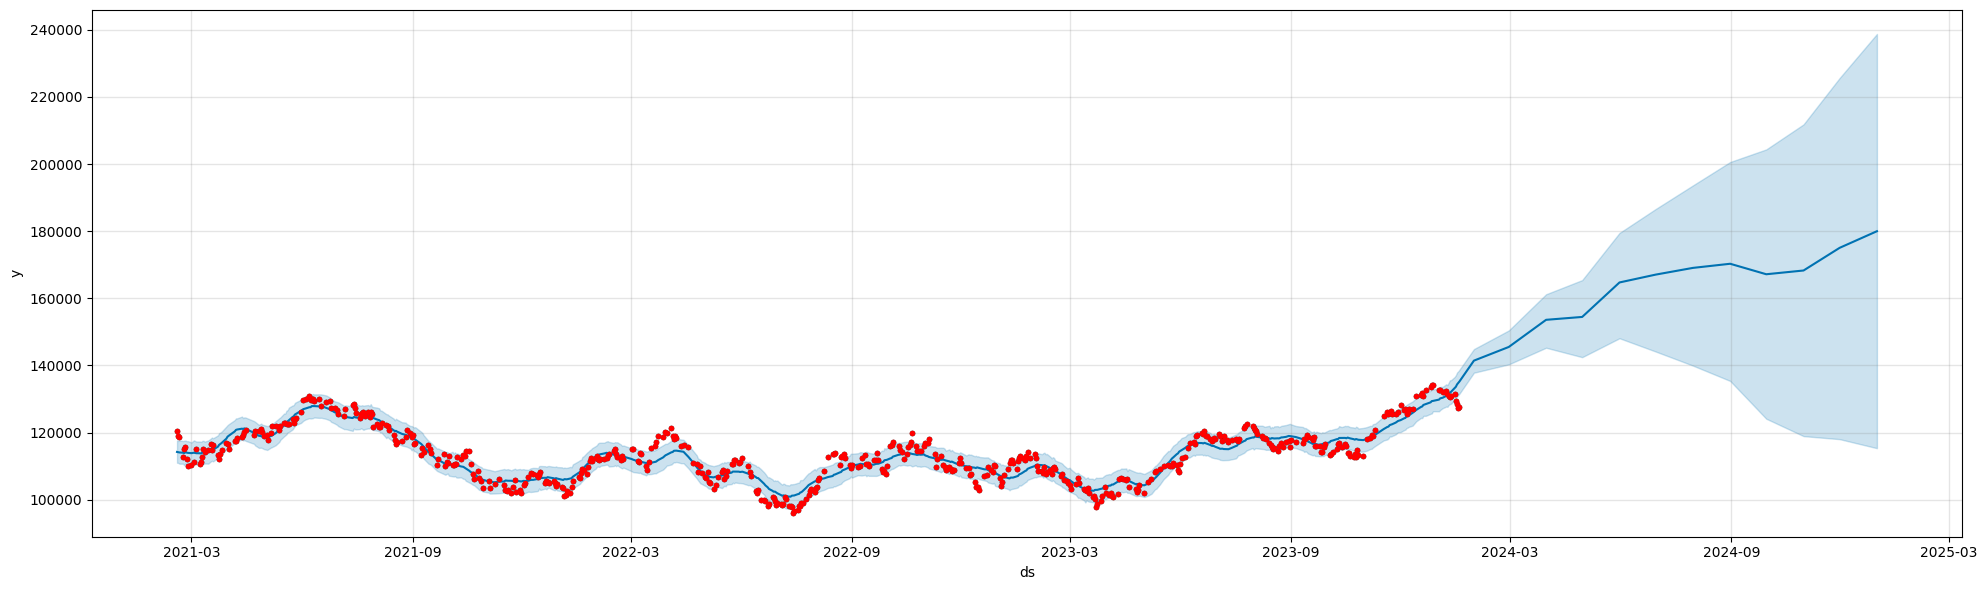

In [42]:
modelo.plot(previsao_2_anos, figsize=(20,6))
plt.plot(treino_dois_anos['ds'], treino_dois_anos['y'], '.r')

In [43]:

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao_2_anos[previsao_cols]
valores_reais = treino_dois_anos[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao_2_anos, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 1.93%


Como podemos ver com a comparação dos resultados de MAPE, o modelo utilizando apenas os dois últimos anos de dados se comporta melhor do que o modelo utilizando a base inteira do IBOVESPA

Vamos agora aplicar o algoritmo LSTM para os mesmos dados